In [1]:
import h5py

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from rfest import splineLG
from rfest import get_stimulus_design_matrix, get_spatial_and_temporal_filters

# Load RGC calcium imaging data

In [2]:
with h5py.File('./data/RGC_dendrite.h5', 'r') as f:
    
    stimulus = np.array(f['stimulus'])
    response = np.array(f['response']) 
    
print("# rois = {}".format(response.shape[0]))

# rois = 19


In [3]:
roi_id = 0
dims = [5, 20, 15]
X = get_stimulus_design_matrix(stimulus, dims[0])
y = response[roi_id] 

# Spline-based Receptive Field Estimation

Raw STA, raw maximum likelihood and spline-based maximum likelihood are calculated for free when `splineLG` class is initialized. Call `splineLG().fit()` to get least-square estimation with ElasticNet (`alpha` control the balance between L1 and L2 regularization, `lambda` control the overall weight of the regularization term).

In [4]:
spl = splineLG(X, y, dims, df_splines=7, compute_mle=True)
spl.fit(num_iters=500, alpha=1, lambd=0.03, verbal=100) # verbal=0: no progress; 
                                                        # verbal=n: print progress at every n steps

Iter	Cost	
0	56.015	
100	0.314	
200	0.275	
300	0.265	
400	0.263	
Stop at 467 steps: cost has been changing less than 1e-5 for 10 steps.


# Plot Results

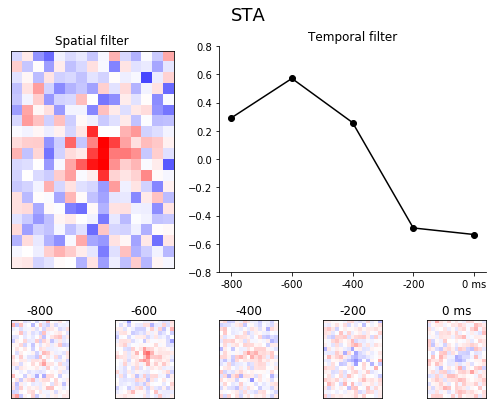

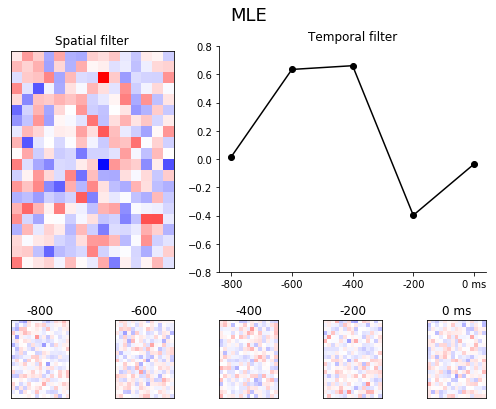

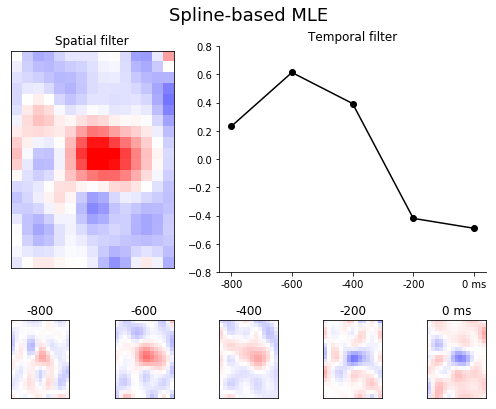

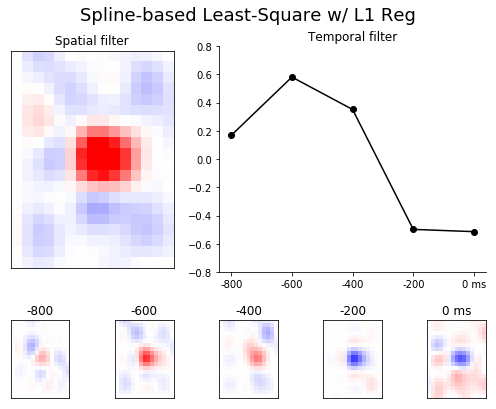

In [5]:
def plot_RF(k, dims, title=''):
    
    import matplotlib.gridspec as gridspec
    
    k_norm = k / np.linalg.norm(k)
    
    sRF, tRF = get_spatial_and_temporal_filters(k_norm, dims)
    
    fig = plt.figure(figsize=(7,6))
    spec = gridspec.GridSpec(ncols=5, nrows=3, figure=fig)
    ax0 = fig.add_subplot(spec[:2, :2])
    ax0.imshow(sRF, origin='lower', cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
    ax0.set_title('Spatial filter')
    ax0.set_xticks([])
    ax0.set_yticks([])
    ax1 = fig.add_subplot(spec[:2, 2:])
    
    labels = ['-800', '-600', '-400', '-200', '0 ms']
    ax1.plot(labels, tRF, 'ko-')
    ax1.set_ylim(-0.8, 0.8)
    ax1.set_title('Temporal filter')
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    
    
    for i in range(dims[0]):
        ax = fig.add_subplot(spec[2, i])
        ax.imshow(k_norm.reshape(dims)[i], origin='lower', cmap=plt.cm.bwr, vmin=-0.2, vmax=0.2)
        ax.set_title(labels[i])
        ax.set_xticks([])
        ax.set_yticks([])
    
    fig.suptitle(title, fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plot_RF(spl.w_sta, dims, 'STA')
plot_RF(spl.w_mle, dims, 'MLE')
plot_RF(spl.w_spl, dims, 'Spline-based MLE')
plot_RF(spl.w_opt, dims, 'Spline-based Least-Square w/ L1 Reg')